100%|██████████| 170M/170M [00:04<00:00, 41.7MB/s]


[SGD] Epoch 1/20 | Train Loss: 1.8794 | Train Acc: 0.3134 | Test Loss: 1.5056 | Test Acc: 0.4624
[SGD] Epoch 2/20 | Train Loss: 1.3700 | Train Acc: 0.5063 | Test Loss: 1.2099 | Test Acc: 0.5681
[SGD] Epoch 3/20 | Train Loss: 1.1324 | Train Acc: 0.5977 | Test Loss: 1.0260 | Test Acc: 0.6390
[SGD] Epoch 4/20 | Train Loss: 0.9576 | Train Acc: 0.6620 | Test Loss: 0.9246 | Test Acc: 0.6811
[SGD] Epoch 5/20 | Train Loss: 0.8300 | Train Acc: 0.7087 | Test Loss: 0.8548 | Test Acc: 0.6949
[SGD] Epoch 6/20 | Train Loss: 0.7355 | Train Acc: 0.7406 | Test Loss: 0.8462 | Test Acc: 0.7073
[SGD] Epoch 7/20 | Train Loss: 0.6453 | Train Acc: 0.7753 | Test Loss: 0.8291 | Test Acc: 0.7156
[SGD] Epoch 8/20 | Train Loss: 0.5684 | Train Acc: 0.8001 | Test Loss: 0.7481 | Test Acc: 0.7500
[SGD] Epoch 9/20 | Train Loss: 0.4927 | Train Acc: 0.8275 | Test Loss: 0.7593 | Test Acc: 0.7487
[SGD] Epoch 10/20 | Train Loss: 0.4241 | Train Acc: 0.8517 | Test Loss: 0.8080 | Test Acc: 0.7485
[SGD] Epoch 11/20 | Train Los

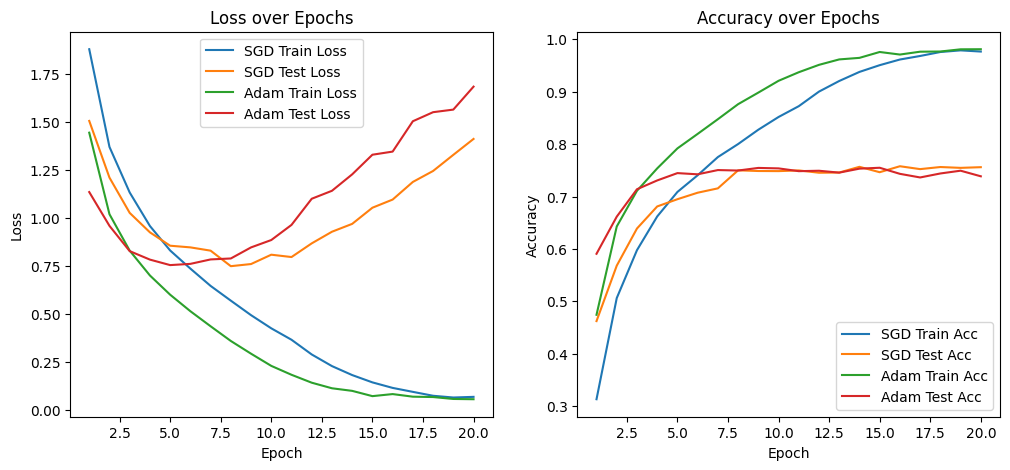

In [ ]:
# Setup & imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),  # 32x16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),  # 64x8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 128x4x4
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.classifier(x)
        return x

# 3. Training and evaluation functions
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_one_epoch(model, optimizer, criterion, dataloader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total

def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total

# 4. Run training with SGD with Momentum and Adam, compare results
import copy

num_epochs = 20
criterion = nn.CrossEntropyLoss()

def run_experiment(optimizer_name):
    model = SimpleCNN().to(device)
    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Optimizer must be 'sgd' or 'adam'")

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, trainloader)
        test_loss, test_acc = evaluate(model, criterion, testloader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"[{optimizer_name.upper()}] Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    return train_losses, train_accs, test_losses, test_accs

sgd_train_loss, sgd_train_acc, sgd_test_loss, sgd_test_acc = run_experiment('sgd')
adam_train_loss, adam_train_acc, adam_test_loss, adam_test_acc = run_experiment('adam')

# 5. Plot results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, sgd_train_loss, label='SGD Train Loss')
plt.plot(epochs, sgd_test_loss, label='SGD Test Loss')
plt.plot(epochs, adam_train_loss, label='Adam Train Loss')
plt.plot(epochs, adam_test_loss, label='Adam Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, sgd_train_acc, label='SGD Train Acc')
plt.plot(epochs, sgd_test_acc, label='SGD Test Acc')
plt.plot(epochs, adam_train_acc, label='Adam Train Acc')
plt.plot(epochs, adam_test_acc, label='Adam Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()
